In [80]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
class Gridworld:
    def __init__(self, size_x, size_y):
        self.size_x = size_x
        self.size_y = size_y
        self.grid = np.zeros((size_x, size_y))
        self.obstacle_percentage = 0.005
    def place_obstacles(self):
        #Draw two line obstacles
        self.grid[500:501,100:400] = 1 # Covers 300 cells 
        self.grid[620:820, 600:601] = 1 # Covers 200 cells
    def place_obstacles_random(self):
        rand_grid = np.random.rand(self.size_x,self.size_y)
        self.grid[rand_grid<self.obstacle_percentage] = 1

class Node:
    def __init__(self, x, y, parent=None):
        self.x = x
        self.y = y
        self.children = []
        self.parent = parent

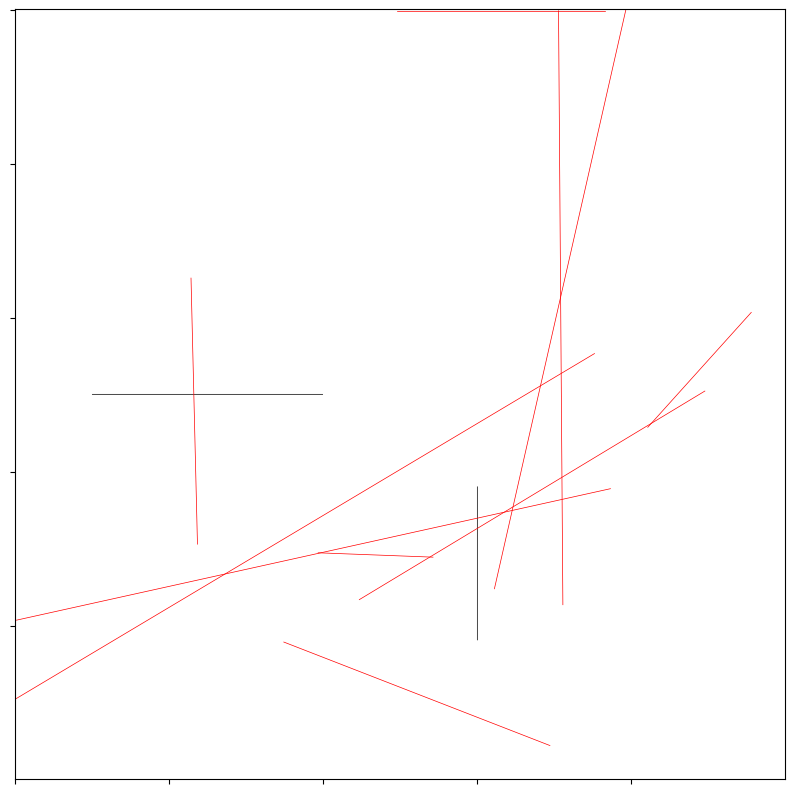

In [91]:
x0 = [2, 2]
n0 = Node(x0[0], x0[1])

n1 = Node(0,0,n0)
n2 = Node(5,5,n1)

gridworld = Gridworld(1000,1000)
gridworld.place_obstacles()

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
plt.imshow(gridworld.grid, cmap='Greys')
ax.set_xticklabels([])
ax.set_yticklabels([])

#Simple line plot test
prev_node = n0
for i in range(10):
    display(fig)
    rand_node = Node(np.random.rand()*gridworld.size_x, np.random.rand()*gridworld.size_y, prev_node)
    plt.plot((rand_node.x,rand_node.y), (prev_node.x,prev_node.y), 'r-', linewidth=0.5)
    prev_node = rand_node
    clear_output(wait = True)


